In [1]:
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import linear_model
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from functools import reduce
from scipy import stats
from functions import *
import pandas as pd
billets=pd.read_csv("DataP6/billets.csv")

## Mission 0 : Analyse des données

In [2]:
billets.describe()
#std nous indique quelles variables ont le plus de variance : la diagonale et la marge inférieure

,length,height_left,height_right,margin_low,margin_up,diagonal
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


In [3]:
billets.info()
#Dataset superclean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
is_genuine      170 non-null bool
length          170 non-null float64
height_left     170 non-null float64
height_right    170 non-null float64
margin_low      170 non-null float64
margin_up       170 non-null float64
diagonal        170 non-null float64
dtypes: bool(1), float64(6)
memory usage: 8.2 KB


In [4]:
billets.groupby("is_genuine").mean()
#plus grandes différences diagonal et marge inf

,length,height_left,height_right,margin_low,margin_up,diagonal
is_genuine,,,,,,
False,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714
True,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200


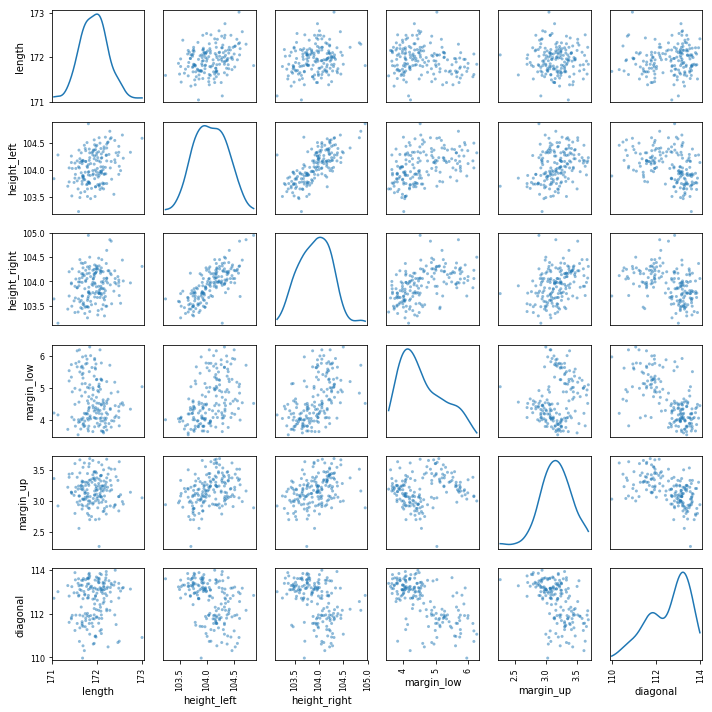

In [5]:
pd.plotting.scatter_matrix(billets.loc[:, "length":"diagonal"], diagonal="kde",
                           figsize=(10,10))

plt.tight_layout()
#plt.savefig("scatter_matrix.png")
plt.show()

In [6]:
#observations:
#lois normales sauf pour la margin_low et la diagonal
#height_right est bizarre
#on voit une belle corrélation entre height_right et height_left
#dans certains il semble qu'il y ait deux groupes

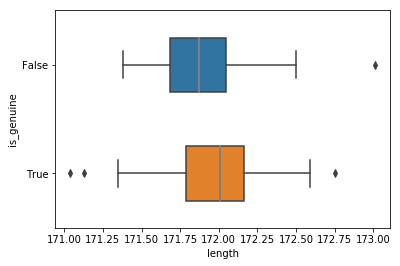

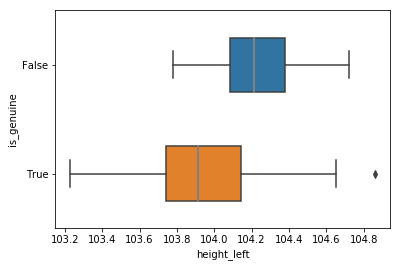

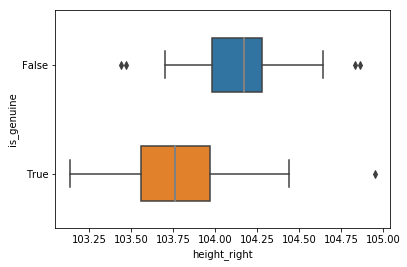

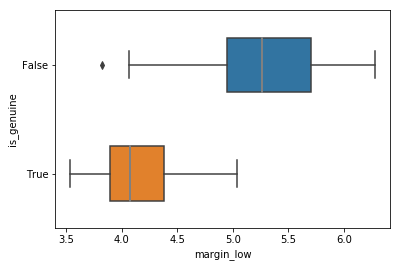

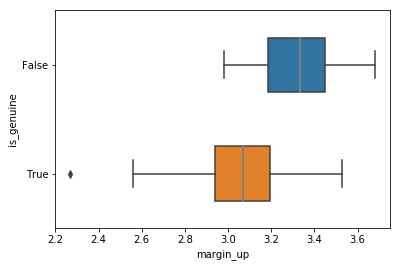

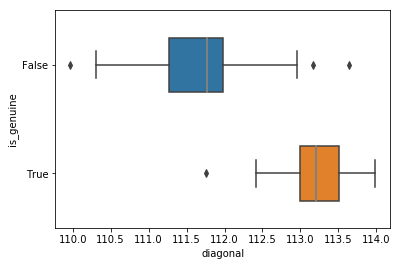

In [7]:
medianprops = dict(linewidth=2, color='grey')
#medianprops = {"linestyle": '-.', 'color': 'red'}

for variable in billets.columns[1:7]:
    sns_plot=sns.boxplot(
        x = billets[variable], 
        y = billets.is_genuine,
        orient = "h",
        medianprops = medianprops,
        width = .5)
    plt.show()
    #sns_plot.get_figure().savefig("{}".format(variable)+"_boxplot.png")

In [8]:
#Regardons les outliers:
#Length:
#True => 34 trop long, 39 et 70 trop petits
#False => 166 bcp trop long

#height_left:
#True => 0 trop grand 

#height_right
#True => 0 trop grand
#False => 112 et 122 trop grands , 141 et 152 trop petits

#margin_low
#False => 160 trop petit

#margin_up
#True => 4 bcp trop petit

#diagonal
#True => 69 trop petit
#False => 151 trop petit, 118 et 145 trop grands

#Pas de conclusions à tirer sur les outliers. Pas vraiment de billets aux dimensions aberrantes.

## Mission 1 : Analyse en compostantes principales

In [9]:
X=billets.drop(columns=["is_genuine"]).values
#Récupération des valeurs

In [10]:
#Centrage-réduction des données
std_scaler=preprocessing.StandardScaler()
std_scaler.fit(X)
X_scaled=std_scaler.transform(X)

In [11]:
#ACP et projection des individus sur les plans factoriels
pca=decomposition.PCA(n_components=6)
pca.fit(X_scaled)
X_projected=pca.transform(X_scaled)

### Eboulis des valeurs propres

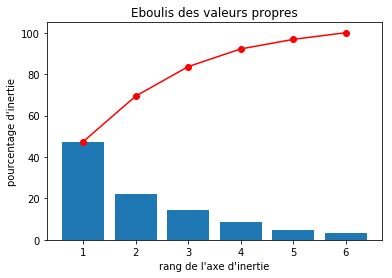

In [12]:
display_scree_plot(pca)
#cet eboulis indique que l'axe F1 a une grande inertie de presque 50%
#on va s'intéresser aux axes F1 et F2
plt.savefig("eboulisVP.png")


In [13]:
plt.show()

### Cercle des corrélations

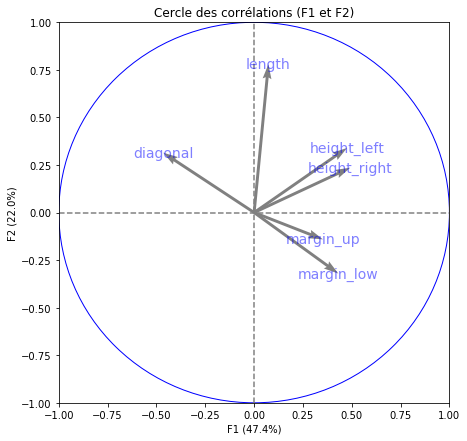

In [14]:
nom_variables=billets.columns[1:7]
pcs=pca.components_
display_circles(pcs,6,pca,[(0,1)],
                labels=nom_variables)
#il est possible de présenter toutes les combinaisons d'axes

In [15]:
#analyse cercle des corrélations:
#length semble le mieux représenté, très corrélé à l'axe F2
#les height et margin semblent corrélées entre elles mais faiblement avec l'axe F1
#je note également une corrélation négative de la diagonale sur l'axe F1


### Projection sur le plan factoriel

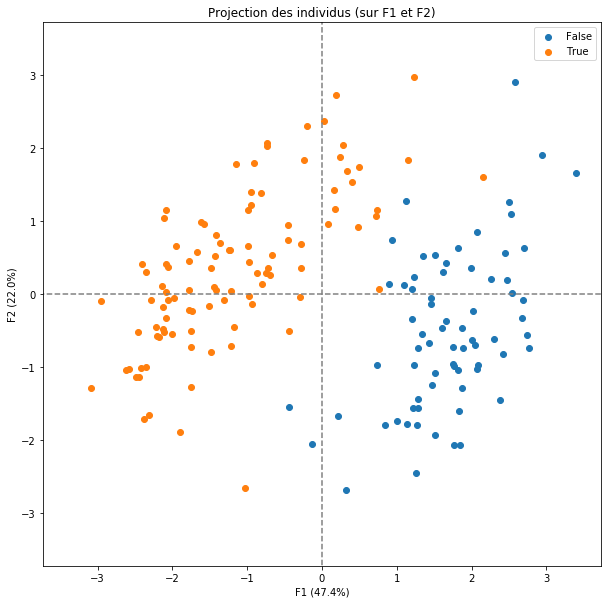

In [16]:
display_factorial_planes(X_projected,6,pca,[(0,1)],
                         illustrative_var=billets.is_genuine)
#visualisation des individus sur le premier plan factoriel
#colorié selon vrai ou faux

### Contribution et qualité de représentation des individus sur le plan factoriel

In [17]:
#contribution des individus dans l'inertie totale
contrib_inertie = pd.DataFrame(np.sum(X_scaled**2,axis=1))
#X_scaled contient toutes les valeurs ramenées a une moyenne de 0, donc prendre toutes ces valeurs aux carrées
#est bien le résultat que nous souhaitons ( carrés des diff )
#La somme (pour chaque individu) des carrés des erreurs(=diff a la moyenne/distance par rapport au centre)
contrib_inertie

#contribution a l'inertie du nuage de points

,0
0,18.410598
1,5.444799
2,4.960527
3,4.805719
4,18.039567
5,11.527985
6,8.029025
7,9.344338
8,5.961640
9,2.373650


In [18]:
carredesdistances = X_scaled**2

#X_scaled pour la qualité de représentation sur les variables initiales
#X_projected pour la qualité de représentation sur les axes trouvés par ACP
#carre des distances, sans faire la somme ( sinon c'est contrib_inertie )

for j in range(X.shape[1]):
     carredesdistances[:,j] = carredesdistances[:,j]/contrib_inertie[0]
qualitrepres=pd.DataFrame({'Qualitrepres F1':carredesdistances[:,0],
                           'Qualitrepres F2':carredesdistances[:,1],
                           'Qualitrepres F3':carredesdistances[:,2],
                           'Qualitrepres F4':carredesdistances[:,3],
                           'Qualitrepres F5':carredesdistances[:,4],
                           'Qualitrepres F6':carredesdistances[:,5]})

In [19]:
qualitrepres

,Qualitrepres F1,Qualitrepres F2,Qualitrepres F3,Qualitrepres F4,Qualitrepres F5,Qualitrepres F6
0,0.009966,0.387059,0.520825,0.000941,0.076901,0.004308
1,0.144681,0.221301,0.087759,0.135876,0.298443,0.111940
2,0.026526,0.214046,0.052319,0.018509,0.306133,0.382468
3,0.044250,0.193034,0.147794,0.330412,0.009522,0.274988
4,0.007140,0.084171,0.016149,0.020710,0.809218,0.062612
5,0.369737,0.334301,0.208711,0.000921,0.050838,0.035493
6,0.258736,0.375682,0.018772,0.104792,0.163983,0.078035
7,0.149710,0.209877,0.306098,0.251014,0.000739,0.082561
8,0.000680,0.587388,0.048866,0.104342,0.076921,0.181803
9,0.180244,0.356907,0.285959,0.000275,0.171615,0.005000


## Mission 2: Classification

### Classification Kmeans

In [20]:
#Classification méthode Kmeans
km=KMeans(2)
km.fit(X_scaled)

# Récupération des clusters attribués à chaque individu
billets["Clusters"]= km.labels_

In [21]:
billets.groupby("Clusters").mean().drop("is_genuine",axis=1)

,length,height_left,height_right,margin_low,margin_up,diagonal
Clusters,,,,,,
0,171.960106,103.911277,103.736383,4.136596,3.050213,113.243085
1,171.916447,104.258158,104.165263,5.200263,3.319079,111.738421


In [22]:
billets.groupby("is_genuine").mean().drop("Clusters",axis=1)

,length,height_left,height_right,margin_low,margin_up,diagonal
is_genuine,,,,,,
False,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714
True,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200


In [23]:
#Cette comparaison permet de voir que le clustering a bien fonctionné :
#la fonction a crée deux groupes qui sont très proches des groupes vrais et faux

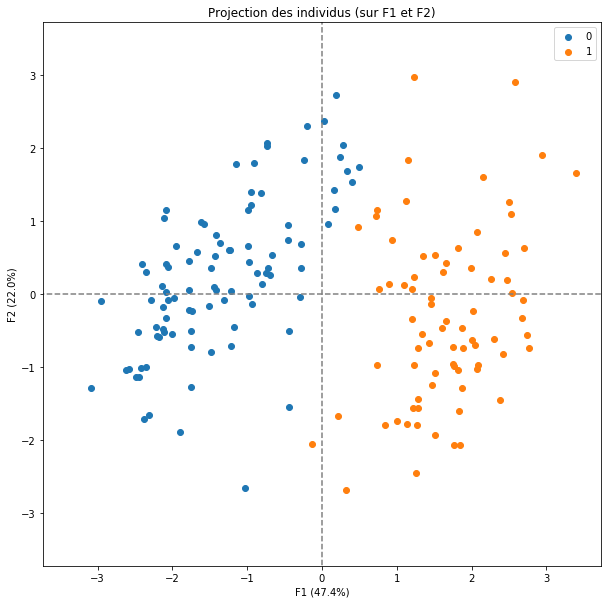

In [24]:
display_factorial_planes(X_projected,6,pca,[(0,1)],
                         illustrative_var=billets.Clusters)
#colorié par clusters trouvés par méthode Kmeans

In [25]:
#analyse visualisation PCA:
#sur F1 et F2 ==>
#grace au coloriage des points, il apparait clairement les deux groupes, vrais et faux

In [26]:
#Classification méthode CHA
#Z=linkage(X_projected,"ward")
#clustersPCA=fcluster(Z,2,criterion="maxclust")
#billets["Clusters"]=clustersPCA

## Mission 3: Régression logistique

### Entraînement du modèle

In [27]:
model_log_reg=linear_model.LogisticRegression()
#création de l'outil

In [28]:
X=billets.loc[:,"length":"diagonal"].values
Y=billets.is_genuine.values
#X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=0)
#récupération des valeurs (et split des données en train et test)

In [29]:
#model_log_reg.fit(X_train,y_train)
model_log_reg.fit(X,Y)
#le modèle est entraîné

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Analyse du modèle

In [30]:
#confusion_matrix(y_test, model_log_reg.predict(X_test))
confusion_matrix(Y, model_log_reg.predict(X))

array([[69,  1],
       [ 1, 99]])

In [31]:
model_log_reg.score(X,Y)

0.9882352941176471

In [32]:
model_log_reg.coef_
#coefficients associés aux variables selon leur importance

array([[-0.37753486, -0.57102422, -1.02979862, -2.81603217, -1.49138411,
         2.2195641 ]])

### Vérifications billets

In [33]:
def verif_billets(csv):
    bills=pd.read_csv(csv)
    id_bills=bills["id"]
    bills_val=bills.loc[:,"length":"diagonal"].values
    predictions=model_log_reg.predict_proba(bills_val)
    for i in range (len(bills)):
        print("billets {} : probabilité que le billet soit vrai = {}%".format(id_bills[i],round(((predictions[i][1])*100),2)))

In [34]:
verif_billets("DataP6/exemple.csv")

billets B_1 : probabilité que le billet soit vrai = 4.07%
billets B_2 : probabilité que le billet soit vrai = 0.95%
billets B_3 : probabilité que le billet soit vrai = 2.85%
billets B_4 : probabilité que le billet soit vrai = 87.6%
billets B_5 : probabilité que le billet soit vrai = 99.63%


In [35]:
pd.read_csv("DataP6/exemple.csv",index_col="id")

,length,height_left,height_right,margin_low,margin_up,diagonal
id,,,,,,
B_1,171.76,104.01,103.54,5.21,3.30,111.42
B_2,171.87,104.17,104.13,6.00,3.31,112.09
B_3,172.00,104.58,104.29,4.99,3.39,111.57
B_4,172.49,104.55,104.34,4.44,3.03,113.20
B_5,171.65,103.63,103.56,3.77,3.16,113.33


In [36]:
billets.groupby("is_genuine").mean()[["margin_low","diagonal"]]

,margin_low,diagonal
is_genuine,,
False,5.281571,111.660714
True,4.143500,113.207200
